ORIGINAL IMAGE TO MODEL


[INFO] Ditemukan 1680 orang dengan ≥2 gambar.
[INFO] Total pasangan: 100 | Match: 50 | Not Match: 50

Processing pair 1: Gian_Marco_0002.jpg vs Gian_Marco_0003.jpg
  Facenet (mtcnn): Similarity = 0.7931
  Facenet512 (mtcnn): Similarity = 0.7191
  ArcFace (retinaface): Similarity = 0.4748

Processing pair 2: Jerry_Regier_0004.jpg vs Jerry_Regier_0002.jpg
  Facenet (mtcnn): Similarity = 0.5635
  Facenet512 (mtcnn): Similarity = 0.6205
  ArcFace (retinaface): Similarity = 0.4882

Processing pair 3: Eduardo_Duhalde_0003.jpg vs Eduardo_Duhalde_0002.jpg
  Facenet (mtcnn): Similarity = 0.0972
  Facenet512 (mtcnn): Similarity = 0.0479
  ArcFace (retinaface): Similarity = 0.1828

Processing pair 4: Terrell_Suggs_0001.jpg vs Terrell_Suggs_0002.jpg
  Facenet (mtcnn): Similarity = 0.8226
  Facenet512 (mtcnn): Similarity = 0.7557
  ArcFace (retinaface): Similarity = 0.6481

Processing pair 5: Filippo_Inzaghi_0002.jpg vs Filippo_Inzaghi_0003.jpg
  Facenet (mtcnn): Similarity = 0.4305
  Facenet512 (

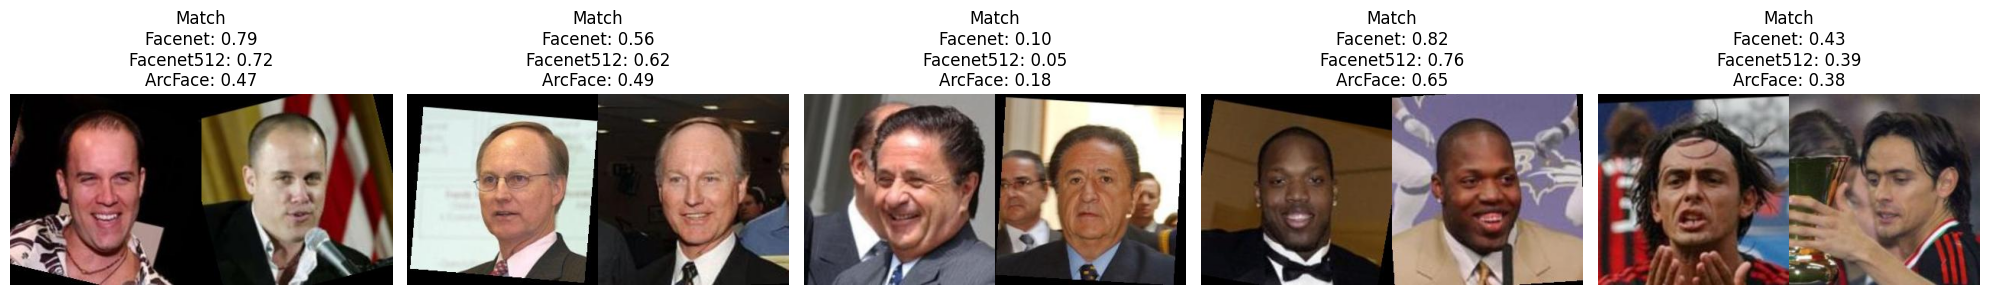


FACE MATCHING RESULTS (SIMILARITY SCORE)
Pair   Label      Model        Similarity Verified
--------------------------------------------------------------------------------
1      Match      Facenet      0.7931     False
1      Match      Facenet512   0.7191     False
1      Match      ArcFace      0.4748     False
2      Match      Facenet      0.5635     False
2      Match      Facenet512   0.6205     False
2      Match      ArcFace      0.4882     False
3      Match      Facenet      0.0972     False
3      Match      Facenet512   0.0479     False
3      Match      ArcFace      0.1828     False
4      Match      Facenet      0.8226     True
4      Match      Facenet512   0.7557     False
4      Match      ArcFace      0.6481     False
5      Match      Facenet      0.4305     False
5      Match      Facenet512   0.3948     False
5      Match      ArcFace      0.3766     False
6      Match      Facenet      0.8083     True
6      Match      Facenet512   0.8366     True
6      Match 

In [ ]:
import os
import random
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from sklearn.metrics.pairwise import cosine_distances
from collections import defaultdict

# Path ke dataset LFW
path = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled"

# Model yang digunakan
models = ['Facenet', 'Facenet512', 'ArcFace']

# === 1. Baca semua folder dengan ≥2 gambar ===
def get_valid_people(dataset_dir):
    data = []
    for label in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label)
        if not os.path.isdir(label_path):
            continue
        
        img_files = [f for f in os.listdir(label_path) 
                     if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        
        if len(img_files) >= 2:
            img_paths = [os.path.join(label_path, f) for f in img_files]
            data.append((label, img_paths))
    
    print(f"[INFO] Ditemukan {len(data)} orang dengan ≥2 gambar.")
    return data

# === 2. Generate 50 Match + 50 Not Match ===
data = get_valid_people(path)

if len(data) < 50:
    n_match = len(data)
else:
    n_match = 50

random.shuffle(data)
data = data[:n_match]

# 50 Match pairs
match_pairs = []
for label, img_paths in data:
    chosen = random.sample(img_paths, 2)
    match_pairs.append((chosen[0], chosen[1]))

# 50 Not match pairs
not_match_pairs = []
all_indices = list(range(len(data)))
while len(not_match_pairs) < 50:
    i, j = random.sample(all_indices, 2)
    if i != j:
        img1 = random.choice(data[i][1])
        img2 = random.choice(data[j][1])
        not_match_pairs.append((img1, img2))

pairs = match_pairs + not_match_pairs
labels = ["Match"] * len(match_pairs) + ["Not Match"] * len(not_match_pairs)

print(f"[INFO] Total pasangan: {len(pairs)} | Match: {len(match_pairs)} | Not Match: {len(not_match_pairs)}")

# === 3. Proses semua pasangan ===
results = []

for idx, (img1_path, img2_path) in enumerate(pairs):
    print(f"\nProcessing pair {idx + 1}: {os.path.basename(img1_path)} vs {os.path.basename(img2_path)}")
    
    model_results = []
    
    for model_name in models:
        try:
            # Gunakan detektor sesuai model
            if model_name == 'ArcFace':
                detector = "retinaface"
            else:
                detector = "mtcnn"  # Untuk Facenet & Facenet512
            
            # Gunakan gambar asli langsung (tanpa preprocessing)
            embedding1 = DeepFace.represent(
                img_path=img1_path,
                model_name=model_name,
                enforce_detection=False,
                detector_backend=detector
            )[0]['embedding']
            
            embedding2 = DeepFace.represent(
                img_path=img2_path,
                model_name=model_name,
                enforce_detection=False,
                detector_backend=detector
            )[0]['embedding']
            
            dist = cosine_distances([embedding1], [embedding2])[0][0]
            similarity = 1 - dist
            
            model_results.append({
                'model': model_name,
                'similarity': similarity,
                'is_same': similarity > 0.8
            })
            print(f"  {model_name} ({detector}): Similarity = {similarity:.4f}")
            
        except Exception as e:
            print(f"  Error with {model_name}: {e}")
            model_results.append({'model': model_name, 'similarity': None, 'is_same': False})
    
    # Untuk plotting: baca gambar asli sebagai RGB
    img1_rgb = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)
    
    results.append({
        'pair_idx': idx,
        'images': (img1_rgb, img2_rgb),
        'label': labels[idx],
        'model_results': model_results
    })

# === 4. Plot hasil (5 pasangan pertama) ===
if results:
    n_plot = min(5, len(results))
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes = axes.ravel()

    for idx in range(n_plot):
        item = results[idx]
        ax = axes[idx]
        combined = np.hstack(item['images'])
        ax.imshow(combined)
        title = f"{item['label']}\n"
        for res in item['model_results']:
            if res['similarity'] is not None:
                title += f"{res['model']}: {res['similarity']:.2f}\n"
        ax.set_title(title.strip())
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# === 5. Tampilkan tabel hasil ===
print("\n" + "="*80)
print("FACE MATCHING RESULTS (SIMILARITY SCORE)")
print("="*80)
print(f"{'Pair':<6} {'Label':<10} {'Model':<12} {'Similarity':<10} {'Verified'}")
print("-"*80)

for item in results:
    for res in item['model_results']:
        sim = f"{res['similarity']:.4f}" if res['similarity'] is not None else "N/A"
        verified = res['is_same'] if res['similarity'] is not None else False
        print(f"{item['pair_idx']+1:<6} {item['label']:<10} {res['model']:<12} {sim:<10} {verified}")

# === 6. Hitung akurasi per model & label ===
match_correct = defaultdict(int)
match_total = defaultdict(int)
not_match_correct = defaultdict(int)
not_match_total = defaultdict(int)

for item in results:
    label = item['label']
    for res in item['model_results']:
        model = res['model']
        pred = res['is_same']
        if label == "Match":
            match_total[model] += 1
            if pred:
                match_correct[model] += 1
        else:
            not_match_total[model] += 1
            if not pred:
                not_match_correct[model] += 1

print("\n" + "="*80)
print("ACCURACY PER MODEL & LABEL")
print("="*80)
print(f"{'Model':<15} {'Match Acc (%)':<15} {'Not Match Acc (%)':<20} {'Overall Acc (%)':<15}")
print("-"*80)

for model in models:
    match_acc = (match_correct[model] / match_total[model] * 100) if match_total[model] > 0 else 0
    not_match_acc = (not_match_correct[model] / not_match_total[model] * 100) if not_match_total[model] > 0 else 0
    overall_acc = ((match_correct[model] + not_match_correct[model]) / 
                   (match_total[model] + not_match_total[model]) * 100) if (match_total[model] + not_match_total[model]) > 0 else 0
    
    print(f"{model:<15} {match_acc:<15.2f} {not_match_acc:<20.2f} {overall_acc:<15.2f}")

EXPERIMENT USING RETINAFACE TO FACENET

[INFO] Ditemukan 1680 orang dengan ≥2 gambar.
[INFO] Total pasangan: 100 | Match: 50 | Not Match: 50

Processing pair 1: Mitchell_Daniels_0001.jpg vs Mitchell_Daniels_0003.jpg
  Facenet (retinaface): Similarity = 0.7844
  Facenet512 (retinaface): Similarity = 0.8653
  ArcFace (retinaface): Similarity = 0.5323

Processing pair 2: Andrew_Cuomo_0001.jpg vs Andrew_Cuomo_0002.jpg
  Facenet (retinaface): Similarity = 0.7561
  Facenet512 (retinaface): Similarity = 0.7253
  ArcFace (retinaface): Similarity = 0.4401

Processing pair 3: Joseph_Deiss_0003.jpg vs Joseph_Deiss_0001.jpg
  Facenet (retinaface): Similarity = 0.6682
  Facenet512 (retinaface): Similarity = 0.8350
  ArcFace (retinaface): Similarity = 0.4996

Processing pair 4: Meghann_Shaughnessy_0001.jpg vs Meghann_Shaughnessy_0002.jpg
  Facenet (retinaface): Similarity = 0.4948
  Facenet512 (retinaface): Similarity = 0.7601
  ArcFace (retinaface): Similarity = 0.5602

Processing pair 5: Pascal_Quignard_0002.jpg vs Pascal_Quignard_0003.

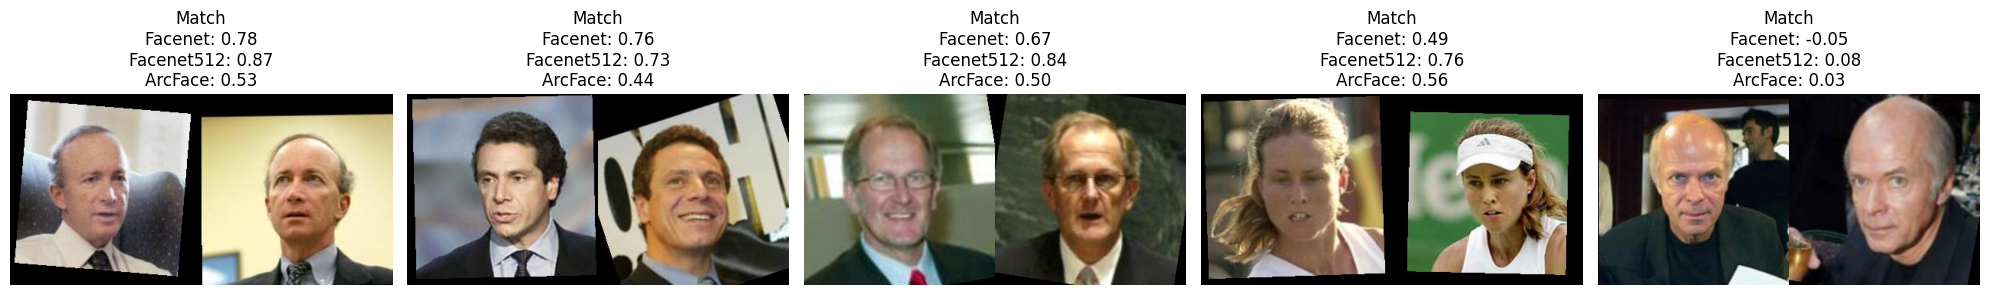


FACE MATCHING RESULTS (SIMILARITY SCORE)
Pair   Label      Model        Similarity Verified
--------------------------------------------------------------------------------
1      Match      Facenet      0.7844     False
1      Match      Facenet512   0.8653     True
1      Match      ArcFace      0.5323     False
2      Match      Facenet      0.7561     False
2      Match      Facenet512   0.7253     False
2      Match      ArcFace      0.4401     False
3      Match      Facenet      0.6682     False
3      Match      Facenet512   0.8350     True
3      Match      ArcFace      0.4996     False
4      Match      Facenet      0.4948     False
4      Match      Facenet512   0.7601     False
4      Match      ArcFace      0.5602     False
5      Match      Facenet      -0.0452    False
5      Match      Facenet512   0.0772     False
5      Match      ArcFace      0.0316     False
6      Match      Facenet      0.8619     True
6      Match      Facenet512   0.8843     True
6      Match  

In [11]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from sklearn.metrics.pairwise import cosine_distances
from collections import defaultdict

# Path ke dataset LFW
path = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled"

# Model yang digunakan
models = ['Facenet', 'Facenet512', 'ArcFace']

# === 1. Baca semua folder dengan ≥2 gambar ===
def get_valid_people(dataset_dir):
    data = []
    for label in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label)
        if not os.path.isdir(label_path):
            continue
        
        img_files = [f for f in os.listdir(label_path) 
                     if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        
        if len(img_files) >= 2:
            img_paths = [os.path.join(label_path, f) for f in img_files]
            data.append((label, img_paths))
    
    print(f"[INFO] Ditemukan {len(data)} orang dengan ≥2 gambar.")
    return data

# === 2. Generate 50 Match + 50 Not Match ===
data = get_valid_people(path)

if len(data) < 50:
    n_match = len(data)
else:
    n_match = 50

random.shuffle(data)
data = data[:n_match]

# 50 Match pairs
match_pairs = []
for label, img_paths in data:
    chosen = random.sample(img_paths, 2)
    match_pairs.append((chosen[0], chosen[1]))

# 50 Not match pairs
not_match_pairs = []
all_indices = list(range(len(data)))
while len(not_match_pairs) < 50:
    i, j = random.sample(all_indices, 2)
    if i != j:
        img1 = random.choice(data[i][1])
        img2 = random.choice(data[j][1])
        not_match_pairs.append((img1, img2))

pairs = match_pairs + not_match_pairs
labels = ["Match"] * len(match_pairs) + ["Not Match"] * len(not_match_pairs)

print(f"[INFO] Total pasangan: {len(pairs)} | Match: {len(match_pairs)} | Not Match: {len(not_match_pairs)}")

# === 3. Proses semua pasangan ===
results = []

for idx, (img1_path, img2_path) in enumerate(pairs):
    print(f"\nProcessing pair {idx + 1}: {os.path.basename(img1_path)} vs {os.path.basename(img2_path)}")
    
    model_results = []
    
    for model_name in models:
        try:
            # Gunakan detektor sesuai model
            if model_name == 'ArcFace':
                detector = "retinaface"
            else:
                detector = "retinaface"  # Untuk Facenet & Facenet512
            
            # Gunakan gambar asli langsung (tanpa preprocessing)
            embedding1 = DeepFace.represent(
                img_path=img1_path,
                model_name=model_name,
                enforce_detection=False,
                detector_backend=detector
            )[0]['embedding']
            
            embedding2 = DeepFace.represent(
                img_path=img2_path,
                model_name=model_name,
                enforce_detection=False,
                detector_backend=detector
            )[0]['embedding']
            
            dist = cosine_distances([embedding1], [embedding2])[0][0]
            similarity = 1 - dist
            
            model_results.append({
                'model': model_name,
                'similarity': similarity,
                'is_same': similarity > 0.8
            })
            print(f"  {model_name} ({detector}): Similarity = {similarity:.4f}")
            
        except Exception as e:
            print(f"  Error with {model_name}: {e}")
            model_results.append({'model': model_name, 'similarity': None, 'is_same': False})
    
    # Untuk plotting: baca gambar asli sebagai RGB
    img1_rgb = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)
    
    results.append({
        'pair_idx': idx,
        'images': (img1_rgb, img2_rgb),
        'label': labels[idx],
        'model_results': model_results
    })

# === 4. Plot hasil (5 pasangan pertama) ===
if results:
    n_plot = min(5, len(results))
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes = axes.ravel()

    for idx in range(n_plot):
        item = results[idx]
        ax = axes[idx]
        combined = np.hstack(item['images'])
        ax.imshow(combined)
        title = f"{item['label']}\n"
        for res in item['model_results']:
            if res['similarity'] is not None:
                title += f"{res['model']}: {res['similarity']:.2f}\n"
        ax.set_title(title.strip())
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# === 5. Tampilkan tabel hasil ===
print("\n" + "="*80)
print("FACE MATCHING RESULTS (SIMILARITY SCORE)")
print("="*80)
print(f"{'Pair':<6} {'Label':<10} {'Model':<12} {'Similarity':<10} {'Verified'}")
print("-"*80)

for item in results:
    for res in item['model_results']:
        sim = f"{res['similarity']:.4f}" if res['similarity'] is not None else "N/A"
        verified = res['is_same'] if res['similarity'] is not None else False
        print(f"{item['pair_idx']+1:<6} {item['label']:<10} {res['model']:<12} {sim:<10} {verified}")

# === 6. Hitung akurasi per model & label ===
match_correct = defaultdict(int)
match_total = defaultdict(int)
not_match_correct = defaultdict(int)
not_match_total = defaultdict(int)

for item in results:
    label = item['label']
    for res in item['model_results']:
        model = res['model']
        pred = res['is_same']
        if label == "Match":
            match_total[model] += 1
            if pred:
                match_correct[model] += 1
        else:
            not_match_total[model] += 1
            if not pred:
                not_match_correct[model] += 1

print("\n" + "="*80)
print("ACCURACY PER MODEL & LABEL")
print("="*80)
print(f"{'Model':<15} {'Match Acc (%)':<15} {'Not Match Acc (%)':<20} {'Overall Acc (%)':<15}")
print("-"*80)

for model in models:
    match_acc = (match_correct[model] / match_total[model] * 100) if match_total[model] > 0 else 0
    not_match_acc = (not_match_correct[model] / not_match_total[model] * 100) if not_match_total[model] > 0 else 0
    overall_acc = ((match_correct[model] + not_match_correct[model]) / 
                   (match_total[model] + not_match_total[model]) * 100) if (match_total[model] + not_match_total[model]) > 0 else 0
    
    print(f"{model:<15} {match_acc:<15.2f} {not_match_acc:<20.2f} {overall_acc:<15.2f}")

RGB -> GRAYSCALE -> INCREASING CONTRAST

[INFO] Ditemukan 1680 orang dengan ≥2 gambar.
[INFO] Total pasangan: 100 | Match: 50 | Not Match: 50

Processing pair 1: Yasar_Yakis_0004.jpg vs Yasar_Yakis_0001.jpg
  Facenet (mtcnn): Similarity = 0.7201
  Facenet512 (mtcnn): Similarity = 0.7286
  ArcFace (retinaface): Similarity = 0.5262

Processing pair 2: Richard_Armitage_0008.jpg vs Richard_Armitage_0009.jpg
  Facenet (mtcnn): Similarity = 0.5301
  Facenet512 (mtcnn): Similarity = 0.5520
  ArcFace (retinaface): Similarity = 0.5876

Processing pair 3: Ann_Veneman_0001.jpg vs Ann_Veneman_0003.jpg
  Facenet (mtcnn): Similarity = 0.7435
  Facenet512 (mtcnn): Similarity = 0.8533
  ArcFace (retinaface): Similarity = 0.7573

Processing pair 4: Princess_Anne_0002.jpg vs Princess_Anne_0001.jpg
  Facenet (mtcnn): Similarity = 0.5534
  Facenet512 (mtcnn): Similarity = 0.6142
  ArcFace (retinaface): Similarity = 0.4022

Processing pair 5: Fran_Drescher_0002.jpg vs Fran_Drescher_0001.jpg
  Facenet (mtcnn): Similarity = 0.7424
  Facenet512 (mtc

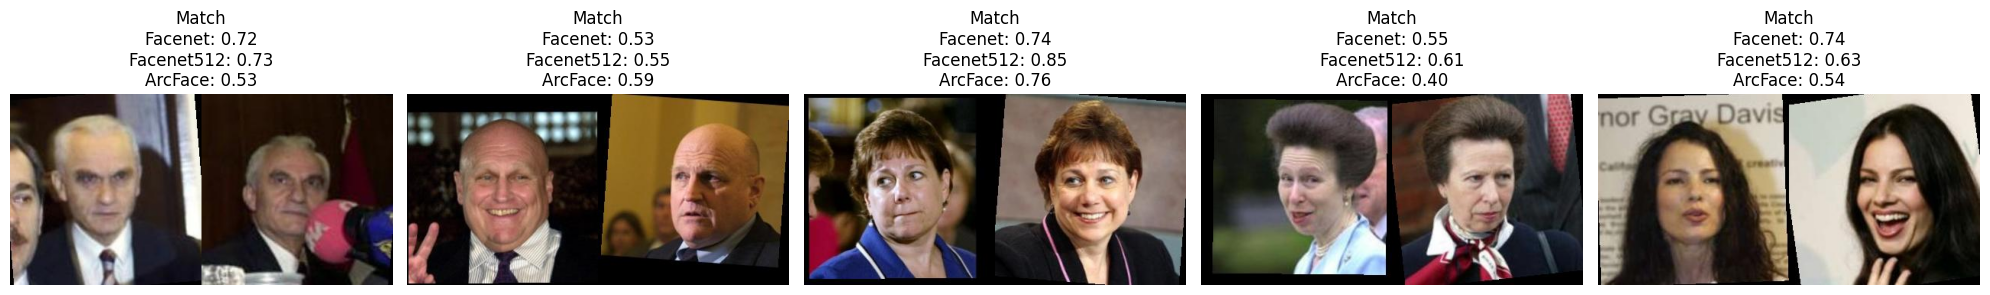


FACE MATCHING RESULTS (SIMILARITY SCORE)
Pair   Label      Model        Similarity Verified
--------------------------------------------------------------------------------
1      Match      Facenet      0.7201     False
1      Match      Facenet512   0.7286     False
1      Match      ArcFace      0.5262     False
2      Match      Facenet      0.5301     False
2      Match      Facenet512   0.5520     False
2      Match      ArcFace      0.5876     False
3      Match      Facenet      0.7435     False
3      Match      Facenet512   0.8533     True
3      Match      ArcFace      0.7573     False
4      Match      Facenet      0.5534     False
4      Match      Facenet512   0.6142     False
4      Match      ArcFace      0.4022     False
5      Match      Facenet      0.7424     False
5      Match      Facenet512   0.6332     False
5      Match      ArcFace      0.5372     False
6      Match      Facenet      0.7156     False
6      Match      Facenet512   0.7757     False
6      Matc

In [3]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from sklearn.metrics.pairwise import cosine_distances
from collections import defaultdict

# Path ke dataset LFW
path = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled"

# Folder sementara untuk simpan gambar hasil preprocessing
TEMP_DIR = "temp_preprocessed"
os.makedirs(TEMP_DIR, exist_ok=True)

# Fungsi preprocessing: Grayscale + CLAHE → RGB (3 channel)
def preprocess_and_save(image_path, output_dir=TEMP_DIR):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise ValueError(f"Gambar tidak ditemukan: {image_path}")
    
    # Grayscale
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_enhanced = clahe.apply(gray)
    
    # Konversi ke RGB (3 channel) → DeepFace butuh 3 channel
    img_rgb = cv2.cvtColor(gray_enhanced, cv2.COLOR_GRAY2RGB)
    
    # Simpan sebagai file sementara (dalam format BGR untuk cv2.imwrite)
    img_bgr_out = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    base_name = os.path.basename(image_path)
    name, ext = os.path.splitext(base_name)
    temp_path = os.path.join(output_dir, f"preprocessed_{name}{ext}")
    cv2.imwrite(temp_path, img_bgr_out)
    
    return temp_path

# Model yang digunakan
models = ['Facenet', 'Facenet512', 'ArcFace']

# === 1. Baca semua folder dengan ≥2 gambar ===
def get_valid_people(dataset_dir):
    data = []
    for label in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label)
        if not os.path.isdir(label_path):
            continue
        
        img_files = [f for f in os.listdir(label_path) 
                     if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        
        if len(img_files) >= 2:
            img_paths = [os.path.join(label_path, f) for f in img_files]
            data.append((label, img_paths))
    
    print(f"[INFO] Ditemukan {len(data)} orang dengan ≥2 gambar.")
    return data

# === 2. Generate 50 Match + 50 Not Match ===
data = get_valid_people(path)

if len(data) < 50:
    n_match = len(data)
else:
    n_match = 50

random.shuffle(data)
data = data[:n_match]

# 50 Match pairs
match_pairs = []
for label, img_paths in data:
    chosen = random.sample(img_paths, 2)
    match_pairs.append((chosen[0], chosen[1]))

# 50 Not match pairs
not_match_pairs = []
all_indices = list(range(len(data)))
while len(not_match_pairs) < 50:
    i, j = random.sample(all_indices, 2)
    if i != j:
        img1 = random.choice(data[i][1])
        img2 = random.choice(data[j][1])
        not_match_pairs.append((img1, img2))

pairs = match_pairs + not_match_pairs
labels = ["Match"] * len(match_pairs) + ["Not Match"] * len(not_match_pairs)

print(f"[INFO] Total pasangan: {len(pairs)} | Match: {len(match_pairs)} | Not Match: {len(not_match_pairs)}")

# === 3. Proses semua pasangan ===
results = []

for idx, (img1_path, img2_path) in enumerate(pairs):
    print(f"\nProcessing pair {idx + 1}: {os.path.basename(img1_path)} vs {os.path.basename(img2_path)}")
    
    try:
        temp1_path = preprocess_and_save(img1_path)
        temp2_path = preprocess_and_save(img2_path)
    except Exception as e:
        print(f"  [SKIP] Gagal preprocess: {e}")
        continue

    model_results = []
    
    for model_name in models:
        try:
            # Gunakan detektor sesuai model
            if model_name == 'ArcFace':
                detector = "retinaface"
            else:
                detector = "mtcnn"  # Untuk Facenet & Facenet512
            
            embedding1 = DeepFace.represent(
                img_path=temp1_path,
                model_name=model_name,
                enforce_detection=False,
                detector_backend=detector
            )[0]['embedding']
            
            embedding2 = DeepFace.represent(
                img_path=temp2_path,
                model_name=model_name,
                enforce_detection=False,
                detector_backend=detector
            )[0]['embedding']
            
            dist = cosine_distances([embedding1], [embedding2])[0][0]
            similarity = 1 - dist
            
            model_results.append({
                'model': model_name,
                'similarity': similarity,
                'is_same': similarity > 0.8
            })
            print(f"  {model_name} ({detector}): Similarity = {similarity:.4f}")
            
        except Exception as e:
            print(f"  Error with {model_name}: {e}")
            model_results.append({'model': model_name, 'similarity': None, 'is_same': False})
    
    # Untuk plotting: baca gambar asli sebagai RGB
    img1_rgb = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)
    
    results.append({
        'pair_idx': idx,
        'images': (img1_rgb, img2_rgb),
        'label': labels[idx],
        'model_results': model_results
    })

# === 4. Plot hasil (5 pasangan pertama) ===
if results:
    n_plot = min(5, len(results))
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes = axes.ravel()

    for idx in range(n_plot):
        item = results[idx]
        ax = axes[idx]
        combined = np.hstack(item['images'])
        ax.imshow(combined)
        title = f"{item['label']}\n"
        for res in item['model_results']:
            if res['similarity'] is not None:
                title += f"{res['model']}: {res['similarity']:.2f}\n"
        ax.set_title(title.strip())
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# === 5. Tampilkan tabel hasil ===
print("\n" + "="*80)
print("FACE MATCHING RESULTS (SIMILARITY SCORE)")
print("="*80)
print(f"{'Pair':<6} {'Label':<10} {'Model':<12} {'Similarity':<10} {'Verified'}")
print("-"*80)

for item in results:
    for res in item['model_results']:
        sim = f"{res['similarity']:.4f}" if res['similarity'] is not None else "N/A"
        verified = res['is_same'] if res['similarity'] is not None else False
        print(f"{item['pair_idx']+1:<6} {item['label']:<10} {res['model']:<12} {sim:<10} {verified}")

# === 6. Hitung akurasi per model & label ===
match_correct = defaultdict(int)
match_total = defaultdict(int)
not_match_correct = defaultdict(int)
not_match_total = defaultdict(int)

for item in results:
    label = item['label']
    for res in item['model_results']:
        model = res['model']
        pred = res['is_same']
        if label == "Match":
            match_total[model] += 1
            if pred:
                match_correct[model] += 1
        else:
            not_match_total[model] += 1
            if not pred:
                not_match_correct[model] += 1

print("\n" + "="*80)
print("ACCURACY PER MODEL & LABEL")
print("="*80)
print(f"{'Model':<15} {'Match Acc (%)':<15} {'Not Match Acc (%)':<20} {'Overall Acc (%)':<15}")
print("-"*80)

for model in models:
    match_acc = (match_correct[model] / match_total[model] * 100) if match_total[model] > 0 else 0
    not_match_acc = (not_match_correct[model] / not_match_total[model] * 100) if not_match_total[model] > 0 else 0
    overall_acc = ((match_correct[model] + not_match_correct[model]) / 
                   (match_total[model] + not_match_total[model]) * 100) if (match_total[model] + not_match_total[model]) > 0 else 0
    
    print(f"{model:<15} {match_acc:<15.2f} {not_match_acc:<20.2f} {overall_acc:<15.2f}")

EXPERIMENT USING RETINAFACE TO FACENET

[INFO] Ditemukan 1680 orang dengan ≥2 gambar.
[INFO] Total pasangan: 100 | Match: 50 | Not Match: 50

Processing pair 1: Robert_Ehrlich_0001.jpg vs Robert_Ehrlich_0002.jpg
  Facenet (retinaface): Similarity = 0.4885
  Facenet512 (retinaface): Similarity = 0.7188
  ArcFace (retinaface): Similarity = 0.5008

Processing pair 2: Rick_Barnes_0003.jpg vs Rick_Barnes_0001.jpg
  Facenet (retinaface): Similarity = 0.8342
  Facenet512 (retinaface): Similarity = 0.8800
  ArcFace (retinaface): Similarity = 0.5299

Processing pair 3: Anthony_Hopkins_0002.jpg vs Anthony_Hopkins_0001.jpg
  Facenet (retinaface): Similarity = 0.8797
  Facenet512 (retinaface): Similarity = 0.7340
  ArcFace (retinaface): Similarity = 0.6970

Processing pair 4: Shane_Warne_0001.jpg vs Shane_Warne_0002.jpg
  Facenet (retinaface): Similarity = 0.3386
  Facenet512 (retinaface): Similarity = 0.5463
  ArcFace (retinaface): Similarity = 0.3854

Processing pair 5: John_Walsh_0002.jpg vs John_Walsh_0001.jpg
  Facenet (retinaface)

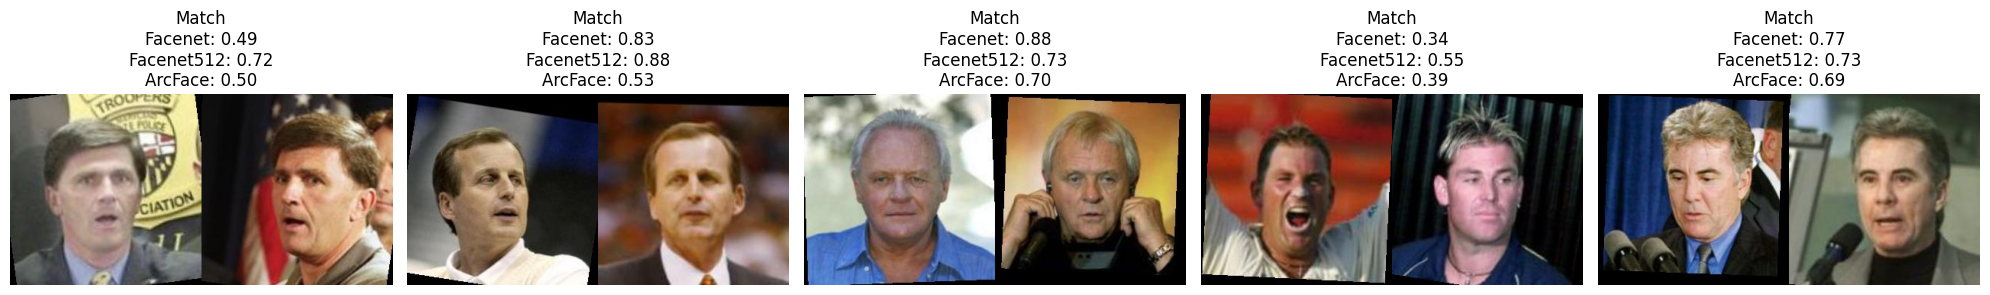


FACE MATCHING RESULTS (SIMILARITY SCORE)
Pair   Label      Model        Similarity Verified
--------------------------------------------------------------------------------
1      Match      Facenet      0.4885     False
1      Match      Facenet512   0.7188     False
1      Match      ArcFace      0.5008     False
2      Match      Facenet      0.8342     True
2      Match      Facenet512   0.8800     True
2      Match      ArcFace      0.5299     False
3      Match      Facenet      0.8797     True
3      Match      Facenet512   0.7340     False
3      Match      ArcFace      0.6970     False
4      Match      Facenet      0.3386     False
4      Match      Facenet512   0.5463     False
4      Match      ArcFace      0.3854     False
5      Match      Facenet      0.7749     False
5      Match      Facenet512   0.7303     False
5      Match      ArcFace      0.6920     False
6      Match      Facenet      0.8766     True
6      Match      Facenet512   0.8917     True
6      Match   

In [4]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from sklearn.metrics.pairwise import cosine_distances
from collections import defaultdict

# Path ke dataset LFW
path = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled"

# Folder sementara untuk simpan gambar hasil preprocessing
TEMP_DIR = "temp_preprocessed"
os.makedirs(TEMP_DIR, exist_ok=True)

# Fungsi preprocessing: Grayscale + CLAHE → RGB (3 channel)
def preprocess_and_save(image_path, output_dir=TEMP_DIR):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise ValueError(f"Gambar tidak ditemukan: {image_path}")
    
    # Grayscale
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_enhanced = clahe.apply(gray)
    
    # Konversi ke RGB (3 channel) → DeepFace butuh 3 channel
    img_rgb = cv2.cvtColor(gray_enhanced, cv2.COLOR_GRAY2RGB)
    
    # Simpan sebagai file sementara (dalam format BGR untuk cv2.imwrite)
    img_bgr_out = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    base_name = os.path.basename(image_path)
    name, ext = os.path.splitext(base_name)
    temp_path = os.path.join(output_dir, f"preprocessed_{name}{ext}")
    cv2.imwrite(temp_path, img_bgr_out)
    
    return temp_path

# Model yang digunakan
models = ['Facenet', 'Facenet512', 'ArcFace']

# === 1. Baca semua folder dengan ≥2 gambar ===
def get_valid_people(dataset_dir):
    data = []
    for label in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label)
        if not os.path.isdir(label_path):
            continue
        
        img_files = [f for f in os.listdir(label_path) 
                     if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        
        if len(img_files) >= 2:
            img_paths = [os.path.join(label_path, f) for f in img_files]
            data.append((label, img_paths))
    
    print(f"[INFO] Ditemukan {len(data)} orang dengan ≥2 gambar.")
    return data

# === 2. Generate 50 Match + 50 Not Match ===
data = get_valid_people(path)

if len(data) < 50:
    n_match = len(data)
else:
    n_match = 50

random.shuffle(data)
data = data[:n_match]

# 50 Match pairs
match_pairs = []
for label, img_paths in data:
    chosen = random.sample(img_paths, 2)
    match_pairs.append((chosen[0], chosen[1]))

# 50 Not match pairs
not_match_pairs = []
all_indices = list(range(len(data)))
while len(not_match_pairs) < 50:
    i, j = random.sample(all_indices, 2)
    if i != j:
        img1 = random.choice(data[i][1])
        img2 = random.choice(data[j][1])
        not_match_pairs.append((img1, img2))

pairs = match_pairs + not_match_pairs
labels = ["Match"] * len(match_pairs) + ["Not Match"] * len(not_match_pairs)

print(f"[INFO] Total pasangan: {len(pairs)} | Match: {len(match_pairs)} | Not Match: {len(not_match_pairs)}")

# === 3. Proses semua pasangan ===
results = []

for idx, (img1_path, img2_path) in enumerate(pairs):
    print(f"\nProcessing pair {idx + 1}: {os.path.basename(img1_path)} vs {os.path.basename(img2_path)}")
    
    try:
        temp1_path = preprocess_and_save(img1_path)
        temp2_path = preprocess_and_save(img2_path)
    except Exception as e:
        print(f"  [SKIP] Gagal preprocess: {e}")
        continue

    model_results = []
    
    for model_name in models:
        try:
            # Gunakan detektor sesuai model
            if model_name == 'ArcFace':
                detector = "retinaface"
            else:
                detector = "retinaface"  # Untuk Facenet & Facenet512
            
            embedding1 = DeepFace.represent(
                img_path=temp1_path,
                model_name=model_name,
                enforce_detection=False,
                detector_backend=detector
            )[0]['embedding']
            
            embedding2 = DeepFace.represent(
                img_path=temp2_path,
                model_name=model_name,
                enforce_detection=False,
                detector_backend=detector
            )[0]['embedding']
            
            dist = cosine_distances([embedding1], [embedding2])[0][0]
            similarity = 1 - dist
            
            model_results.append({
                'model': model_name,
                'similarity': similarity,
                'is_same': similarity > 0.8
            })
            print(f"  {model_name} ({detector}): Similarity = {similarity:.4f}")
            
        except Exception as e:
            print(f"  Error with {model_name}: {e}")
            model_results.append({'model': model_name, 'similarity': None, 'is_same': False})
    
    # Untuk plotting: baca gambar asli sebagai RGB
    img1_rgb = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)
    
    results.append({
        'pair_idx': idx,
        'images': (img1_rgb, img2_rgb),
        'label': labels[idx],
        'model_results': model_results
    })

# === 4. Plot hasil (5 pasangan pertama) ===
if results:
    n_plot = min(5, len(results))
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes = axes.ravel()

    for idx in range(n_plot):
        item = results[idx]
        ax = axes[idx]
        combined = np.hstack(item['images'])
        ax.imshow(combined)
        title = f"{item['label']}\n"
        for res in item['model_results']:
            if res['similarity'] is not None:
                title += f"{res['model']}: {res['similarity']:.2f}\n"
        ax.set_title(title.strip())
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# === 5. Tampilkan tabel hasil ===
print("\n" + "="*80)
print("FACE MATCHING RESULTS (SIMILARITY SCORE)")
print("="*80)
print(f"{'Pair':<6} {'Label':<10} {'Model':<12} {'Similarity':<10} {'Verified'}")
print("-"*80)

for item in results:
    for res in item['model_results']:
        sim = f"{res['similarity']:.4f}" if res['similarity'] is not None else "N/A"
        verified = res['is_same'] if res['similarity'] is not None else False
        print(f"{item['pair_idx']+1:<6} {item['label']:<10} {res['model']:<12} {sim:<10} {verified}")

# === 6. Hitung akurasi per model & label ===
match_correct = defaultdict(int)
match_total = defaultdict(int)
not_match_correct = defaultdict(int)
not_match_total = defaultdict(int)

for item in results:
    label = item['label']
    for res in item['model_results']:
        model = res['model']
        pred = res['is_same']
        if label == "Match":
            match_total[model] += 1
            if pred:
                match_correct[model] += 1
        else:
            not_match_total[model] += 1
            if not pred:
                not_match_correct[model] += 1

print("\n" + "="*80)
print("ACCURACY PER MODEL & LABEL")
print("="*80)
print(f"{'Model':<15} {'Match Acc (%)':<15} {'Not Match Acc (%)':<20} {'Overall Acc (%)':<15}")
print("-"*80)

for model in models:
    match_acc = (match_correct[model] / match_total[model] * 100) if match_total[model] > 0 else 0
    not_match_acc = (not_match_correct[model] / not_match_total[model] * 100) if not_match_total[model] > 0 else 0
    overall_acc = ((match_correct[model] + not_match_correct[model]) / 
                   (match_total[model] + not_match_total[model]) * 100) if (match_total[model] + not_match_total[model]) > 0 else 0
    
    print(f"{model:<15} {match_acc:<15.2f} {not_match_acc:<20.2f} {overall_acc:<15.2f}")

RGB -> BGR

[INFO] Ditemukan 1680 orang dengan ≥2 gambar.
[INFO] Total pasangan: 100 | Match: 50 | Not Match: 50

Processing pair 1: Imad_Moustapha_0002.jpg vs Imad_Moustapha_0001.jpg
  Facenet (retinaface): Similarity = 0.9330
  Facenet512 (retinaface): Similarity = 0.9567
  ArcFace (retinaface): Similarity = 0.9000

Processing pair 2: Alexander_Downer_0002.jpg vs Alexander_Downer_0004.jpg
  Facenet (retinaface): Similarity = 0.6528
  Facenet512 (retinaface): Similarity = 0.7455
  ArcFace (retinaface): Similarity = 0.6643

Processing pair 3: Ellen_DeGeneres_0001.jpg vs Ellen_DeGeneres_0002.jpg
  Facenet (retinaface): Similarity = 0.7513
  Facenet512 (retinaface): Similarity = 0.7907
  ArcFace (retinaface): Similarity = 0.6485

Processing pair 4: Michael_Leavitt_0002.jpg vs Michael_Leavitt_0001.jpg
  Facenet (retinaface): Similarity = 0.7060
  Facenet512 (retinaface): Similarity = 0.6887
  ArcFace (retinaface): Similarity = 0.4104

Processing pair 5: George_Tenet_0002.jpg vs George_Tenet_0001.jpg


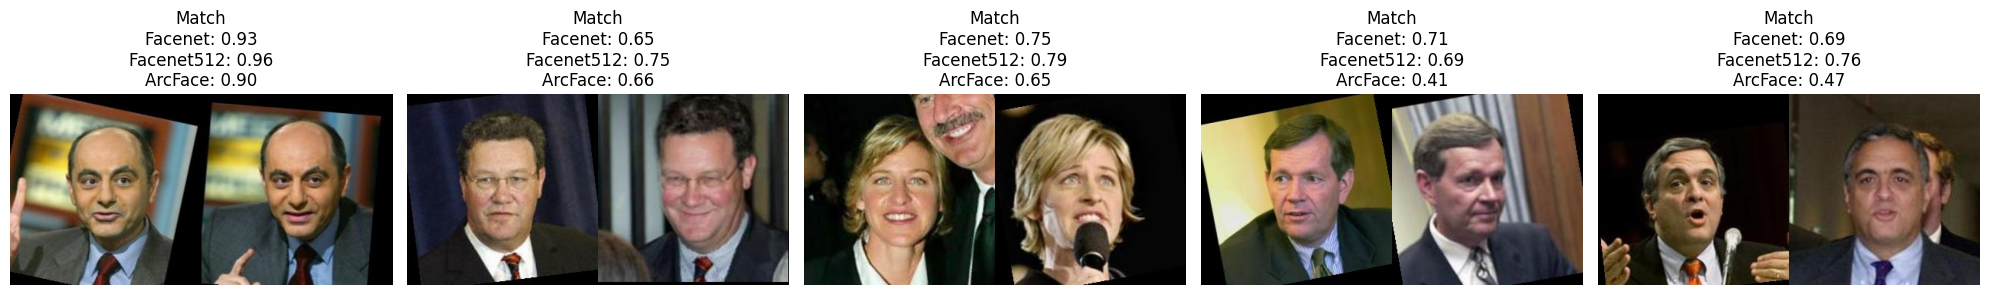


FACE MATCHING RESULTS (SIMILARITY SCORE)
Pair   Label      Model        Similarity Verified
--------------------------------------------------------------------------------
1      Match      Facenet      0.9330     True
1      Match      Facenet512   0.9567     True
1      Match      ArcFace      0.9000     True
2      Match      Facenet      0.6528     False
2      Match      Facenet512   0.7455     False
2      Match      ArcFace      0.6643     False
3      Match      Facenet      0.7513     False
3      Match      Facenet512   0.7907     False
3      Match      ArcFace      0.6485     False
4      Match      Facenet      0.7060     False
4      Match      Facenet512   0.6887     False
4      Match      ArcFace      0.4104     False
5      Match      Facenet      0.6949     False
5      Match      Facenet512   0.7572     False
5      Match      ArcFace      0.4680     False
6      Match      Facenet      0.4154     False
6      Match      Facenet512   0.3926     False
6      Match 

In [5]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from sklearn.metrics.pairwise import cosine_distances
from collections import defaultdict

# Path ke dataset LFW
path = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled"

# Folder sementara untuk simpan gambar hasil konversi
TEMP_DIR = "temp_bgr"
os.makedirs(TEMP_DIR, exist_ok=True)

# Fungsi: baca gambar asli → pastikan format BGR → simpan
def convert_to_bgr_and_save(image_path, output_dir=TEMP_DIR):
    """
    Baca gambar, pastikan dalam format BGR (OpenCV default),
    lalu simpan sebagai file sementara.
    """
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise ValueError(f"Gambar tidak ditemukan: {image_path}")
    
    # OpenCV sudah baca sebagai BGR → tidak perlu konversi
    base_name = os.path.basename(image_path)
    name, ext = os.path.splitext(base_name)
    temp_path = os.path.join(output_dir, f"bgr_{name}{ext}")
    cv2.imwrite(temp_path, img_bgr)  # Simpan sebagai BGR
    
    return temp_path

# Model yang digunakan
models = ['Facenet', 'Facenet512', 'ArcFace']

# === 1. Baca semua folder dengan ≥2 gambar ===
def get_valid_people(dataset_dir):
    data = []
    for label in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label)
        if not os.path.isdir(label_path):
            continue
        
        img_files = [f for f in os.listdir(label_path) 
                     if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        
        if len(img_files) >= 2:
            img_paths = [os.path.join(label_path, f) for f in img_files]
            data.append((label, img_paths))
    
    print(f"[INFO] Ditemukan {len(data)} orang dengan ≥2 gambar.")
    return data

# === 2. Generate 50 Match + 50 Not Match ===
data = get_valid_people(path)

if len(data) < 50:
    n_match = len(data)
else:
    n_match = 50

random.shuffle(data)
data = data[:n_match]

# 50 Match pairs
match_pairs = []
for label, img_paths in data:
    chosen = random.sample(img_paths, 2)
    match_pairs.append((chosen[0], chosen[1]))

# 50 Not match pairs
not_match_pairs = []
all_indices = list(range(len(data)))
while len(not_match_pairs) < 50:
    i, j = random.sample(all_indices, 2)
    if i != j:
        img1 = random.choice(data[i][1])
        img2 = random.choice(data[j][1])
        not_match_pairs.append((img1, img2))

pairs = match_pairs + not_match_pairs
labels = ["Match"] * len(match_pairs) + ["Not Match"] * len(not_match_pairs)

print(f"[INFO] Total pasangan: {len(pairs)} | Match: {len(match_pairs)} | Not Match: {len(not_match_pairs)}")

# === 3. Proses semua pasangan ===
results = []

for idx, (img1_path, img2_path) in enumerate(pairs):
    print(f"\nProcessing pair {idx + 1}: {os.path.basename(img1_path)} vs {os.path.basename(img2_path)}")
    
    try:
        # Simpan gambar asli sebagai BGR (sebenarnya sudah BGR)
        temp1_path = convert_to_bgr_and_save(img1_path)
        temp2_path = convert_to_bgr_and_save(img2_path)
    except Exception as e:
        print(f"  [SKIP] Gagal baca gambar: {e}")
        continue

    model_results = []
    
    for model_name in models:
        try:
            # Gunakan retinaface untuk semua model (sesuai permintaan)
            detector = "retinaface"
            
            embedding1 = DeepFace.represent(
                img_path=temp1_path,
                model_name=model_name,
                enforce_detection=False,
                detector_backend=detector
            )[0]['embedding']
            
            embedding2 = DeepFace.represent(
                img_path=temp2_path,
                model_name=model_name,
                enforce_detection=False,
                detector_backend=detector
            )[0]['embedding']
            
            dist = cosine_distances([embedding1], [embedding2])[0][0]
            similarity = 1 - dist
            
            model_results.append({
                'model': model_name,
                'similarity': similarity,
                'is_same': similarity > 0.8
            })
            print(f"  {model_name} ({detector}): Similarity = {similarity:.4f}")
            
        except Exception as e:
            print(f"  Error with {model_name}: {e}")
            model_results.append({'model': model_name, 'similarity': None, 'is_same': False})
    
    # Untuk plotting: baca gambar asli sebagai RGB
    img1_rgb = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)
    
    results.append({
        'pair_idx': idx,
        'images': (img1_rgb, img2_rgb),
        'label': labels[idx],
        'model_results': model_results
    })

# === 4. Plot hasil (5 pasangan pertama) ===
if results:
    n_plot = min(5, len(results))
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes = axes.ravel()

    for idx in range(n_plot):
        item = results[idx]
        ax = axes[idx]
        combined = np.hstack(item['images'])
        ax.imshow(combined)
        title = f"{item['label']}\n"
        for res in item['model_results']:
            if res['similarity'] is not None:
                title += f"{res['model']}: {res['similarity']:.2f}\n"
        ax.set_title(title.strip())
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# === 5. Tampilkan tabel hasil ===
print("\n" + "="*80)
print("FACE MATCHING RESULTS (SIMILARITY SCORE)")
print("="*80)
print(f"{'Pair':<6} {'Label':<10} {'Model':<12} {'Similarity':<10} {'Verified'}")
print("-"*80)

for item in results:
    for res in item['model_results']:
        sim = f"{res['similarity']:.4f}" if res['similarity'] is not None else "N/A"
        verified = res['is_same'] if res['similarity'] is not None else False
        print(f"{item['pair_idx']+1:<6} {item['label']:<10} {res['model']:<12} {sim:<10} {verified}")

# === 6. Hitung akurasi per model & label ===
match_correct = defaultdict(int)
match_total = defaultdict(int)
not_match_correct = defaultdict(int)
not_match_total = defaultdict(int)

for item in results:
    label = item['label']
    for res in item['model_results']:
        model = res['model']
        pred = res['is_same']
        if label == "Match":
            match_total[model] += 1
            if pred:
                match_correct[model] += 1
        else:
            not_match_total[model] += 1
            if not pred:
                not_match_correct[model] += 1

print("\n" + "="*80)
print("ACCURACY PER MODEL & LABEL")
print("="*80)
print(f"{'Model':<15} {'Match Acc (%)':<15} {'Not Match Acc (%)':<20} {'Overall Acc (%)':<15}")
print("-"*80)

for model in models:
    match_acc = (match_correct[model] / match_total[model] * 100) if match_total[model] > 0 else 0
    not_match_acc = (not_match_correct[model] / not_match_total[model] * 100) if not_match_total[model] > 0 else 0
    overall_acc = ((match_correct[model] + not_match_correct[model]) / 
                   (match_total[model] + not_match_total[model]) * 100) if (match_total[model] + not_match_total[model]) > 0 else 0
    
    print(f"{model:<15} {match_acc:<15.2f} {not_match_acc:<20.2f} {overall_acc:<15.2f}")

EXPERIMENT USING RETINAFACE TO FACENET

[INFO] Ditemukan 1680 orang dengan ≥2 gambar.
[INFO] Total pasangan: 100 | Match: 50 | Not Match: 50

Processing pair 1: Mark_Philippoussis_0003.jpg vs Mark_Philippoussis_0011.jpg
  Facenet (mtcnn): Similarity = 0.6194
  Facenet512 (mtcnn): Similarity = 0.5908
  ArcFace (retinaface): Similarity = 0.4688

Processing pair 2: Dominik_Garcia-Lorido_0002.jpg vs Dominik_Garcia-Lorido_0001.jpg
  Facenet (mtcnn): Similarity = 0.7582
  Facenet512 (mtcnn): Similarity = 0.6834
  ArcFace (retinaface): Similarity = 0.6074

Processing pair 3: Paris_Hilton_0001.jpg vs Paris_Hilton_0002.jpg
  Facenet (mtcnn): Similarity = 0.8950
  Facenet512 (mtcnn): Similarity = 0.8713
  ArcFace (retinaface): Similarity = 0.7802

Processing pair 4: Surakait_Sathirathai_0001.jpg vs Surakait_Sathirathai_0002.jpg
  Facenet (mtcnn): Similarity = 0.4807
  Facenet512 (mtcnn): Similarity = 0.6735
  ArcFace (retinaface): Similarity = 0.4331

Processing pair 5: Duane_Lee_Chapman_0001.jpg vs Duane_Lee_Chapman_0002.jpg
  Facene

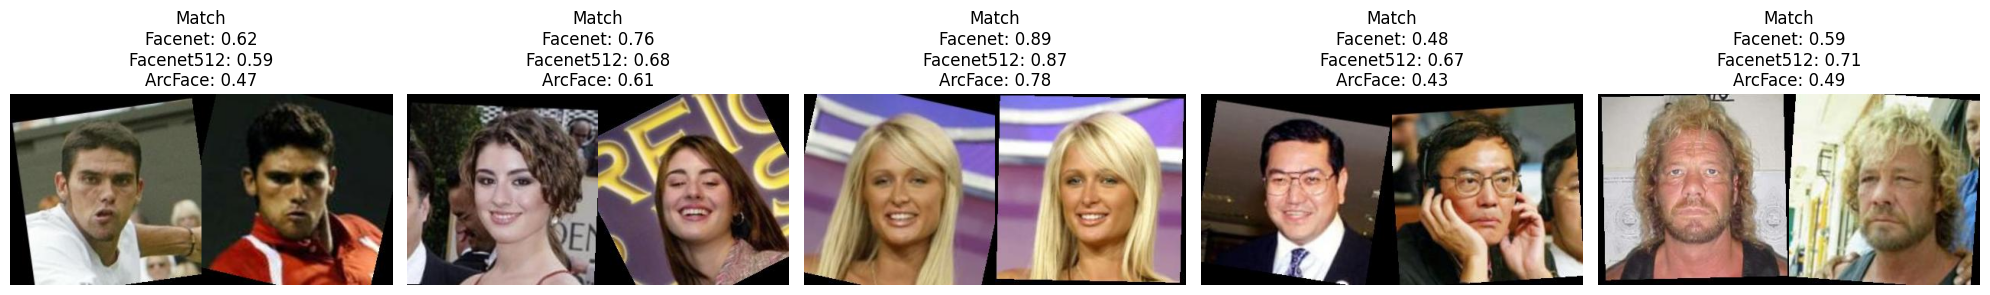


FACE MATCHING RESULTS (SIMILARITY SCORE)
Pair   Label      Model        Similarity Verified
--------------------------------------------------------------------------------
1      Match      Facenet      0.6194     False
1      Match      Facenet512   0.5908     False
1      Match      ArcFace      0.4688     False
2      Match      Facenet      0.7582     False
2      Match      Facenet512   0.6834     False
2      Match      ArcFace      0.6074     False
3      Match      Facenet      0.8950     True
3      Match      Facenet512   0.8713     True
3      Match      ArcFace      0.7802     False
4      Match      Facenet      0.4807     False
4      Match      Facenet512   0.6735     False
4      Match      ArcFace      0.4331     False
5      Match      Facenet      0.5929     False
5      Match      Facenet512   0.7144     False
5      Match      ArcFace      0.4906     False
6      Match      Facenet      0.5083     False
6      Match      Facenet512   0.4593     False
6      Match

In [2]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from sklearn.metrics.pairwise import cosine_distances
from collections import defaultdict

# Path ke dataset LFW
path = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled"

# Folder sementara untuk simpan gambar hasil konversi
TEMP_DIR = "temp_bgr"
os.makedirs(TEMP_DIR, exist_ok=True)

# Fungsi: baca gambar asli → pastikan format BGR → simpan
def convert_to_bgr_and_save(image_path, output_dir=TEMP_DIR):
    """
    Baca gambar, pastikan dalam format BGR (OpenCV default),
    lalu simpan sebagai file sementara.
    """
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise ValueError(f"Gambar tidak ditemukan: {image_path}")
    
    # OpenCV sudah baca sebagai BGR → tidak perlu konversi
    base_name = os.path.basename(image_path)
    name, ext = os.path.splitext(base_name)
    temp_path = os.path.join(output_dir, f"bgr_{name}{ext}")
    cv2.imwrite(temp_path, img_bgr)  # Simpan sebagai BGR
    
    return temp_path

# Model yang digunakan
models = ['Facenet', 'Facenet512', 'ArcFace']

# === 1. Baca semua folder dengan ≥2 gambar ===
def get_valid_people(dataset_dir):
    data = []
    for label in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label)
        if not os.path.isdir(label_path):
            continue
        
        img_files = [f for f in os.listdir(label_path) 
                     if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        
        if len(img_files) >= 2:
            img_paths = [os.path.join(label_path, f) for f in img_files]
            data.append((label, img_paths))
    
    print(f"[INFO] Ditemukan {len(data)} orang dengan ≥2 gambar.")
    return data

# === 2. Generate 50 Match + 50 Not Match ===
data = get_valid_people(path)

if len(data) < 50:
    n_match = len(data)
else:
    n_match = 50

random.shuffle(data)
data = data[:n_match]

# 50 Match pairs
match_pairs = []
for label, img_paths in data:
    chosen = random.sample(img_paths, 2)
    match_pairs.append((chosen[0], chosen[1]))

# 50 Not match pairs
not_match_pairs = []
all_indices = list(range(len(data)))
while len(not_match_pairs) < 50:
    i, j = random.sample(all_indices, 2)
    if i != j:
        img1 = random.choice(data[i][1])
        img2 = random.choice(data[j][1])
        not_match_pairs.append((img1, img2))

pairs = match_pairs + not_match_pairs
labels = ["Match"] * len(match_pairs) + ["Not Match"] * len(not_match_pairs)

print(f"[INFO] Total pasangan: {len(pairs)} | Match: {len(match_pairs)} | Not Match: {len(not_match_pairs)}")

# === 3. Proses semua pasangan ===
results = []

for idx, (img1_path, img2_path) in enumerate(pairs):
    print(f"\nProcessing pair {idx + 1}: {os.path.basename(img1_path)} vs {os.path.basename(img2_path)}")
    
    try:
        # Simpan gambar asli sebagai BGR (sebenarnya sudah BGR)
        temp1_path = convert_to_bgr_and_save(img1_path)
        temp2_path = convert_to_bgr_and_save(img2_path)
    except Exception as e:
        print(f"  [SKIP] Gagal baca gambar: {e}")
        continue

    model_results = []
    
    for model_name in models:
        try:
             # Gunakan detektor sesuai model
            if model_name == 'ArcFace':
                detector = "retinaface"
            else:
                detector = "mtcnn"  # Untuk Facenet & Facenet512
            embedding1 = DeepFace.represent(
                img_path=temp1_path,
                model_name=model_name,
                enforce_detection=False,
                detector_backend=detector
            )[0]['embedding']
            
            embedding2 = DeepFace.represent(
                img_path=temp2_path,
                model_name=model_name,
                enforce_detection=False,
                detector_backend=detector
            )[0]['embedding']
            
            dist = cosine_distances([embedding1], [embedding2])[0][0]
            similarity = 1 - dist
            
            model_results.append({
                'model': model_name,
                'similarity': similarity,
                'is_same': similarity > 0.8
            })
            print(f"  {model_name} ({detector}): Similarity = {similarity:.4f}")
            
        except Exception as e:
            print(f"  Error with {model_name}: {e}")
            model_results.append({'model': model_name, 'similarity': None, 'is_same': False})
    
    # Untuk plotting: baca gambar asli sebagai RGB
    img1_rgb = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)
    
    results.append({
        'pair_idx': idx,
        'images': (img1_rgb, img2_rgb),
        'label': labels[idx],
        'model_results': model_results
    })

# === 4. Plot hasil (5 pasangan pertama) ===
if results:
    n_plot = min(5, len(results))
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes = axes.ravel()

    for idx in range(n_plot):
        item = results[idx]
        ax = axes[idx]
        combined = np.hstack(item['images'])
        ax.imshow(combined)
        title = f"{item['label']}\n"
        for res in item['model_results']:
            if res['similarity'] is not None:
                title += f"{res['model']}: {res['similarity']:.2f}\n"
        ax.set_title(title.strip())
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# === 5. Tampilkan tabel hasil ===
print("\n" + "="*80)
print("FACE MATCHING RESULTS (SIMILARITY SCORE)")
print("="*80)
print(f"{'Pair':<6} {'Label':<10} {'Model':<12} {'Similarity':<10} {'Verified'}")
print("-"*80)

for item in results:
    for res in item['model_results']:
        sim = f"{res['similarity']:.4f}" if res['similarity'] is not None else "N/A"
        verified = res['is_same'] if res['similarity'] is not None else False
        print(f"{item['pair_idx']+1:<6} {item['label']:<10} {res['model']:<12} {sim:<10} {verified}")

# === 6. Hitung akurasi per model & label ===
match_correct = defaultdict(int)
match_total = defaultdict(int)
not_match_correct = defaultdict(int)
not_match_total = defaultdict(int)

for item in results:
    label = item['label']
    for res in item['model_results']:
        model = res['model']
        pred = res['is_same']
        if label == "Match":
            match_total[model] += 1
            if pred:
                match_correct[model] += 1
        else:
            not_match_total[model] += 1
            if not pred:
                not_match_correct[model] += 1

print("\n" + "="*80)
print("ACCURACY PER MODEL & LABEL")
print("="*80)
print(f"{'Model':<15} {'Match Acc (%)':<15} {'Not Match Acc (%)':<20} {'Overall Acc (%)':<15}")
print("-"*80)

for model in models:
    match_acc = (match_correct[model] / match_total[model] * 100) if match_total[model] > 0 else 0
    not_match_acc = (not_match_correct[model] / not_match_total[model] * 100) if not_match_total[model] > 0 else 0
    overall_acc = ((match_correct[model] + not_match_correct[model]) / 
                   (match_total[model] + not_match_total[model]) * 100) if (match_total[model] + not_match_total[model]) > 0 else 0
    
    print(f"{model:<15} {match_acc:<15.2f} {not_match_acc:<20.2f} {overall_acc:<15.2f}")

Experiement-3:
- Image Augmentation as Post Processing
  - Horizontal Flip
  - Grayscale + Increase Brightness
  - Rotate 0-15 degree
  - Random Contras
  - AVG all embedding above

[INFO] Ditemukan 1680 orang dengan ≥2 gambar.
[INFO] Total pasangan: 100 | Match: 50 | Not Match: 50

Processing pair 1: Dick_Latessa_0002.jpg vs Dick_Latessa_0001.jpg
  Facenet (retinaface): Similarity = 0.5615
  Facenet512 (retinaface): Similarity = 0.6439
  ArcFace (retinaface): Similarity = 0.5327

Processing pair 2: Neri_Marcore_0002.jpg vs Neri_Marcore_0002.jpg
  Facenet (retinaface): Similarity = 0.9999
  Facenet512 (retinaface): Similarity = 0.9986
  ArcFace (retinaface): Similarity = 0.9985

Processing pair 3: Lisa_Marie_Presley_0002.jpg vs Lisa_Marie_Presley_0002.jpg
  Facenet (retinaface): Similarity = 0.9999
  Facenet512 (retinaface): Similarity = 0.9993
  ArcFace (retinaface): Similarity = 0.9987

Processing pair 4: Binyamin_Ben-Eliezer_0003.jpg vs Binyamin_Ben-Eliezer_0002.jpg
  Facenet (retinaface): Similarity = 0.8214
  Facenet512 (retinaface): Similarity = 0.7596
  ArcFace (retinaface): Similarity = 0.6528

Processing pair 5: Lou_Piniella_0001.jpg vs Lou_Piniella_0001.

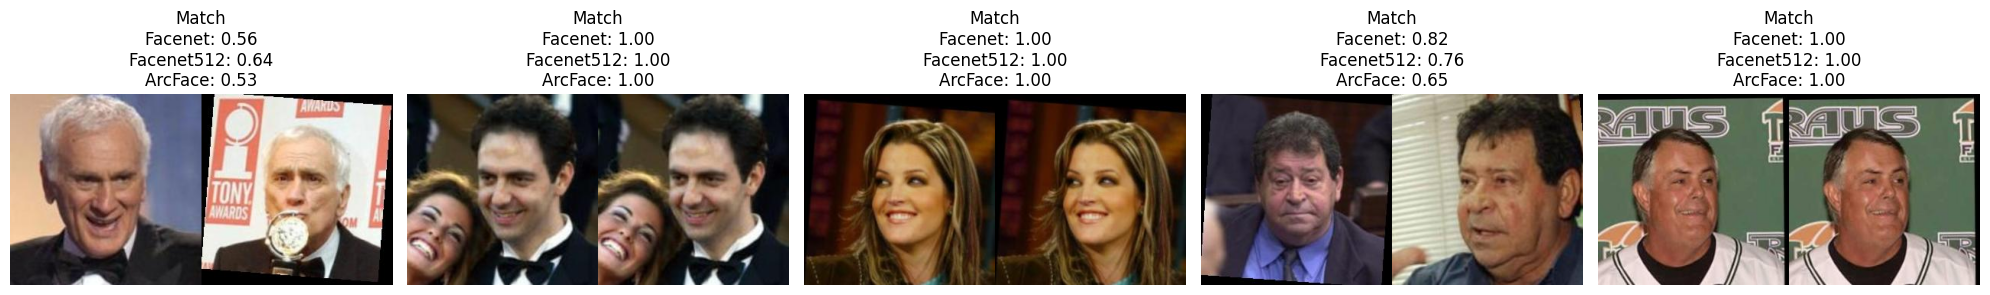


FACE MATCHING RESULTS (SIMILARITY SCORE)
Pair   Label      Model        Similarity Verified
--------------------------------------------------------------------------------
1      Match      Facenet      0.5615     False
1      Match      Facenet512   0.6439     False
1      Match      ArcFace      0.5327     False
2      Match      Facenet      0.9999     True
2      Match      Facenet512   0.9986     True
2      Match      ArcFace      0.9985     True
3      Match      Facenet      0.9999     True
3      Match      Facenet512   0.9993     True
3      Match      ArcFace      0.9987     True
4      Match      Facenet      0.8214     True
4      Match      Facenet512   0.7596     False
4      Match      ArcFace      0.6528     False
5      Match      Facenet      0.9995     True
5      Match      Facenet512   0.9995     True
5      Match      ArcFace      0.9988     True
6      Match      Facenet      0.6668     False
6      Match      Facenet512   0.6623     False
6      Match      Ar

In [3]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from sklearn.metrics.pairwise import cosine_distances
from collections import defaultdict

# Path ke dataset LFW
path = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled"

# Folder sementara
TEMP_DIR = "temp_aug"
os.makedirs(TEMP_DIR, exist_ok=True)

# === Fungsi Augmentasi ===
def augment_image(img_bgr):
    """Return list of 5 images: [original, flip, gray+bright, rotate, contrast]"""
    h, w = img_bgr.shape[:2]
    aug_images = []

    # 1. Original
    aug_images.append(img_bgr)

    # 2. Horizontal Flip
    flipped = cv2.flip(img_bgr, 1)
    aug_images.append(flipped)

    # 3. Grayscale + Increase Brightness
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    bright = cv2.convertScaleAbs(gray, alpha=1.0, beta=50)  # +50 brightness
    gray_bgr = cv2.cvtColor(bright, cv2.COLOR_GRAY2BGR)
    aug_images.append(gray_bgr)

    # 4. Rotate 0-15 degrees
    angle = random.uniform(0, 15)
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    rotated = cv2.warpAffine(img_bgr, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    aug_images.append(rotated)

    # 5. Random Contrast
    alpha = random.uniform(0.8, 1.2)  # 0.8 = darker, 1.2 = brighter
    contrast = cv2.convertScaleAbs(img_bgr, alpha=alpha, beta=0)
    aug_images.append(contrast)

    return aug_images

def save_augmented_images(image_path, output_dir=TEMP_DIR):
    """Simpan 5 versi augmentasi, kembalikan list path"""
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise ValueError(f"Gambar tidak ditemukan: {image_path}")
    
    aug_images = augment_image(img_bgr)
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    paths = []
    for i, img in enumerate(aug_images):
        temp_path = os.path.join(output_dir, f"{base_name}_aug{i}.jpg")
        cv2.imwrite(temp_path, img)
        paths.append(temp_path)
    return paths

# Model yang digunakan
models = ['Facenet', 'Facenet512', 'ArcFace']

# === Helper: Dapatkan embedding rata-rata dari 5 versi ===
def get_averaged_embedding(img_path, model_name, detector="retinaface"):
    try:
        aug_paths = save_augmented_images(img_path)
        embeddings = []
        for p in aug_paths:
            emb = DeepFace.represent(
                img_path=p,
                model_name=model_name,
                detector_backend=detector,
                enforce_detection=False,
                align=True
            )[0]['embedding']
            embeddings.append(emb)
        # Rata-ratakan semua embedding
        avg_emb = np.mean(embeddings, axis=0)
        return avg_emb / np.linalg.norm(avg_emb)  # L2 normalize
    except Exception as e:
        print(f"  [Embedding Error] {img_path}: {e}")
        return None

# === 1. Baca semua folder dengan ≥2 gambar ===
def get_valid_people(dataset_dir):
    data = []
    for label in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label)
        if not os.path.isdir(label_path):
            continue
        img_files = [f for f in os.listdir(label_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        if len(img_files) >= 2:
            img_paths = [os.path.join(label_path, f) for f in img_files]
            data.append((label, img_paths))
    print(f"[INFO] Ditemukan {len(data)} orang dengan ≥2 gambar.")
    return data

# === 2. Generate 50 Match + 50 Not Match ===
data = get_valid_people(path)
n_match = min(50, len(data))
random.shuffle(data)
data = data[:n_match]

match_pairs = [(random.sample(imgs, 2)[0], random.sample(imgs, 2)[1]) for _, imgs in data[:50]]
not_match_pairs = []
all_indices = list(range(len(data)))
while len(not_match_pairs) < 50:
    i, j = random.sample(all_indices, 2)
    if i != j:
        img1 = random.choice(data[i][1])
        img2 = random.choice(data[j][1])
        not_match_pairs.append((img1, img2))

pairs = match_pairs + not_match_pairs
labels = ["Match"] * 50 + ["Not Match"] * 50

print(f"[INFO] Total pasangan: {len(pairs)} | Match: 50 | Not Match: 50")

# === 3. Proses semua pasangan ===
results = []
for idx, (img1_path, img2_path) in enumerate(pairs):
    print(f"\nProcessing pair {idx + 1}: {os.path.basename(img1_path)} vs {os.path.basename(img2_path)}")
    model_results = []
    for model_name in models:
        try:
            emb1 = get_averaged_embedding(img1_path, model_name)
            emb2 = get_averaged_embedding(img2_path, model_name)
            if emb1 is None or emb2 is None:
                raise ValueError("Embedding gagal")
            similarity = 1 - cosine_distances([emb1], [emb2])[0][0]
            model_results.append({
                'model': model_name,
                'similarity': similarity,
                'is_same': similarity > 0.8
            })
            print(f"  {model_name} (retinaface): Similarity = {similarity:.4f}")
        except Exception as e:
            print(f"  Error with {model_name}: {e}")
            model_results.append({'model': model_name, 'similarity': None, 'is_same': False})
    
    # Untuk plotting: gambar asli
    img1_rgb = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)
    results.append({
        'pair_idx': idx,
        'images': (img1_rgb, img2_rgb),
        'label': labels[idx],
        'model_results': model_results
    })

# === 4. Plot hasil (5 pasangan pertama) ===
if results:
    n_plot = min(5, len(results))
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes = axes.ravel()

    for idx in range(n_plot):
        item = results[idx]
        ax = axes[idx]
        combined = np.hstack(item['images'])
        ax.imshow(combined)
        title = f"{item['label']}\n"
        for res in item['model_results']:
            if res['similarity'] is not None:
                title += f"{res['model']}: {res['similarity']:.2f}\n"
        ax.set_title(title.strip())
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# === 5. Tampilkan tabel hasil ===
print("\n" + "="*80)
print("FACE MATCHING RESULTS (SIMILARITY SCORE)")
print("="*80)
print(f"{'Pair':<6} {'Label':<10} {'Model':<12} {'Similarity':<10} {'Verified'}")
print("-"*80)

for item in results:
    for res in item['model_results']:
        sim = f"{res['similarity']:.4f}" if res['similarity'] is not None else "N/A"
        verified = res['is_same'] if res['similarity'] is not None else False
        print(f"{item['pair_idx']+1:<6} {item['label']:<10} {res['model']:<12} {sim:<10} {verified}")

# === 6. Hitung akurasi per model & label ===
match_correct = defaultdict(int)
match_total = defaultdict(int)
not_match_correct = defaultdict(int)
not_match_total = defaultdict(int)

for item in results:
    label = item['label']
    for res in item['model_results']:
        model = res['model']
        pred = res['is_same']
        if label == "Match":
            match_total[model] += 1
            if pred:
                match_correct[model] += 1
        else:
            not_match_total[model] += 1
            if not pred:
                not_match_correct[model] += 1

print("\n" + "="*80)
print("ACCURACY PER MODEL & LABEL")
print("="*80)
print(f"{'Model':<15} {'Match Acc (%)':<15} {'Not Match Acc (%)':<20} {'Overall Acc (%)':<15}")
print("-"*80)

for model in models:
    match_acc = (match_correct[model] / match_total[model] * 100) if match_total[model] > 0 else 0
    not_match_acc = (not_match_correct[model] / not_match_total[model] * 100) if not_match_total[model] > 0 else 0
    overall_acc = ((match_correct[model] + not_match_correct[model]) / 
                   (match_total[model] + not_match_total[model]) * 100) if (match_total[model] + not_match_total[model]) > 0 else 0
    
    print(f"{model:<15} {match_acc:<15.2f} {not_match_acc:<20.2f} {overall_acc:<15.2f}")

CHANGING FACENET DETECTOR TO RETINAFACE

[INFO] Ditemukan 1680 orang dengan ≥2 gambar.
[INFO] Total pasangan: 100 | Match: 50 | Not Match: 50

Processing pair 1: Jose_Mourinho_0002.jpg vs Jose_Mourinho_0001.jpg
  Facenet (retinaface): Similarity = 0.6255
  Facenet512 (retinaface): Similarity = 0.7281
  ArcFace (retinaface): Similarity = 0.4411

Processing pair 2: Dan_Wheldon_0002.jpg vs Dan_Wheldon_0001.jpg
  Facenet (retinaface): Similarity = 0.6064
  Facenet512 (retinaface): Similarity = 0.6449
  ArcFace (retinaface): Similarity = 0.4917

Processing pair 3: Tommy_Thompson_0001.jpg vs Tommy_Thompson_0008.jpg
  Facenet (retinaface): Similarity = 0.6899
  Facenet512 (retinaface): Similarity = 0.7578
  ArcFace (retinaface): Similarity = 0.5043

Processing pair 4: Chick_Hearn_0003.jpg vs Chick_Hearn_0001.jpg
  Facenet (retinaface): Similarity = 0.8103
  Facenet512 (retinaface): Similarity = 0.9474
  ArcFace (retinaface): Similarity = 0.7602

Processing pair 5: Matthew_Broderick_0002.jpg vs Matthew_Broderick_0003.jpg
  Facenet (r

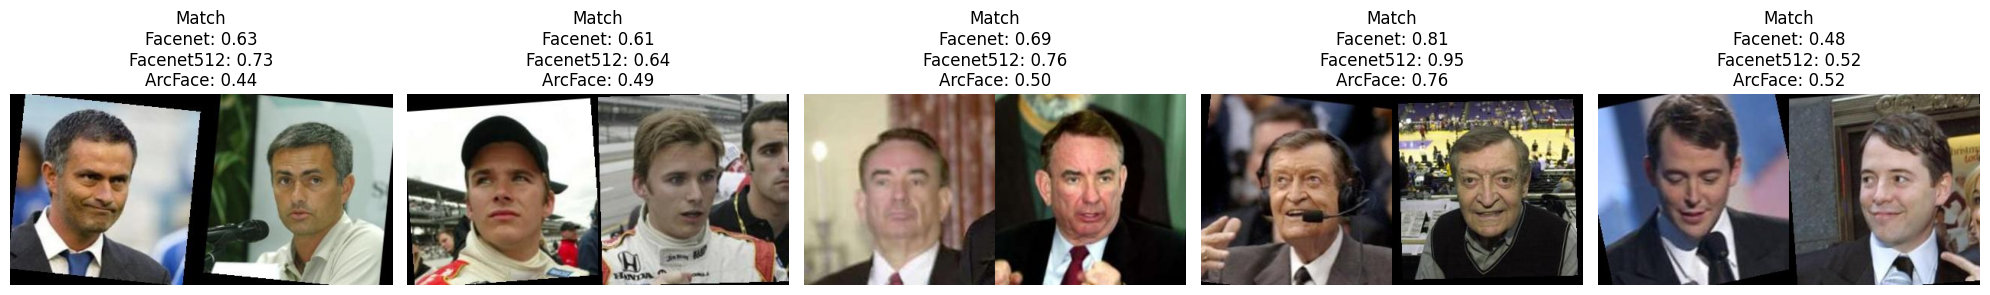


FACE MATCHING RESULTS (SIMILARITY SCORE)
Pair   Label      Model        Similarity Verified
--------------------------------------------------------------------------------
1      Match      Facenet      0.6255     False
1      Match      Facenet512   0.7281     False
1      Match      ArcFace      0.4411     False
2      Match      Facenet      0.6064     False
2      Match      Facenet512   0.6449     False
2      Match      ArcFace      0.4917     False
3      Match      Facenet      0.6899     False
3      Match      Facenet512   0.7578     False
3      Match      ArcFace      0.5043     False
4      Match      Facenet      0.8103     True
4      Match      Facenet512   0.9474     True
4      Match      ArcFace      0.7602     False
5      Match      Facenet      0.4758     False
5      Match      Facenet512   0.5242     False
5      Match      ArcFace      0.5168     False
6      Match      Facenet      0.7867     False
6      Match      Facenet512   0.7882     False
6      Match

In [4]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from sklearn.metrics.pairwise import cosine_distances
from collections import defaultdict

# Path ke dataset LFW
path = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled"

# Folder sementara
TEMP_DIR = "temp_aug"
os.makedirs(TEMP_DIR, exist_ok=True)

# === Fungsi Augmentasi ===
def augment_image(img_bgr):
    """Return list of 5 images: [original, flip, gray+bright, rotate, contrast]"""
    h, w = img_bgr.shape[:2]
    aug_images = []

    # 1. Original
    aug_images.append(img_bgr)

    # 2. Horizontal Flip
    flipped = cv2.flip(img_bgr, 1)
    aug_images.append(flipped)

    # 3. Grayscale + Increase Brightness
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    bright = cv2.convertScaleAbs(gray, alpha=1.0, beta=50)  # +50 brightness
    gray_bgr = cv2.cvtColor(bright, cv2.COLOR_GRAY2BGR)
    aug_images.append(gray_bgr)

    # 4. Rotate 0-15 degrees
    angle = random.uniform(0, 15)
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    rotated = cv2.warpAffine(img_bgr, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    aug_images.append(rotated)

    # 5. Random Contrast
    alpha = random.uniform(0.8, 1.2)  # 0.8 = darker, 1.2 = brighter
    contrast = cv2.convertScaleAbs(img_bgr, alpha=alpha, beta=0)
    aug_images.append(contrast)

    return aug_images

def save_augmented_images(image_path, output_dir=TEMP_DIR):
    """Simpan 5 versi augmentasi, kembalikan list path"""
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise ValueError(f"Gambar tidak ditemukan: {image_path}")
    
    aug_images = augment_image(img_bgr)
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    paths = []
    for i, img in enumerate(aug_images):
        temp_path = os.path.join(output_dir, f"{base_name}_aug{i}.jpg")
        cv2.imwrite(temp_path, img)
        paths.append(temp_path)
    return paths

# Model yang digunakan
models = ['Facenet', 'Facenet512', 'ArcFace']

# === Helper: Dapatkan embedding rata-rata dari 5 versi ===
def get_averaged_embedding(img_path, model_name):
    # Pilih detektor berdasarkan model
    if model_name == "ArcFace":
        detector = "retinaface"
    else:  # Facenet, Facenet512
        detector = "mtcnn"
    
    try:
        aug_paths = save_augmented_images(img_path)
        embeddings = []
        for p in aug_paths:
            emb = DeepFace.represent(
                img_path=p,
                model_name=model_name,
                detector_backend=detector,
                enforce_detection=False,
                align=True
            )[0]['embedding']
            embeddings.append(emb)
        avg_emb = np.mean(embeddings, axis=0)
        return avg_emb / np.linalg.norm(avg_emb)
    except Exception as e:
        print(f"  [Embedding Error] {img_path}: {e}")
        return None

# === 1. Baca semua folder dengan ≥2 gambar ===
def get_valid_people(dataset_dir):
    data = []
    for label in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label)
        if not os.path.isdir(label_path):
            continue
        img_files = [f for f in os.listdir(label_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        if len(img_files) >= 2:
            img_paths = [os.path.join(label_path, f) for f in img_files]
            data.append((label, img_paths))
    print(f"[INFO] Ditemukan {len(data)} orang dengan ≥2 gambar.")
    return data

# === 2. Generate 50 Match + 50 Not Match ===
data = get_valid_people(path)
n_match = min(50, len(data))
random.shuffle(data)
data = data[:n_match]

match_pairs = [(random.sample(imgs, 2)[0], random.sample(imgs, 2)[1]) for _, imgs in data[:50]]
not_match_pairs = []
all_indices = list(range(len(data)))
while len(not_match_pairs) < 50:
    i, j = random.sample(all_indices, 2)
    if i != j:
        img1 = random.choice(data[i][1])
        img2 = random.choice(data[j][1])
        not_match_pairs.append((img1, img2))

pairs = match_pairs + not_match_pairs
labels = ["Match"] * 50 + ["Not Match"] * 50

print(f"[INFO] Total pasangan: {len(pairs)} | Match: 50 | Not Match: 50")

# === 3. Proses semua pasangan ===
results = []
for idx, (img1_path, img2_path) in enumerate(pairs):
    print(f"\nProcessing pair {idx + 1}: {os.path.basename(img1_path)} vs {os.path.basename(img2_path)}")
    model_results = []
    for model_name in models:
        try:
            emb1 = get_averaged_embedding(img1_path, model_name)
            emb2 = get_averaged_embedding(img2_path, model_name)
            if emb1 is None or emb2 is None:
                raise ValueError("Embedding gagal")
            similarity = 1 - cosine_distances([emb1], [emb2])[0][0]
            model_results.append({
                'model': model_name,
                'similarity': similarity,
                'is_same': similarity > 0.8
            })
            print(f"  {model_name} (retinaface): Similarity = {similarity:.4f}")
        except Exception as e:
            print(f"  Error with {model_name}: {e}")
            model_results.append({'model': model_name, 'similarity': None, 'is_same': False})
    
    # Untuk plotting: gambar asli
    img1_rgb = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)
    results.append({
        'pair_idx': idx,
        'images': (img1_rgb, img2_rgb),
        'label': labels[idx],
        'model_results': model_results
    })

# === 4. Plot hasil (5 pasangan pertama) ===
if results:
    n_plot = min(5, len(results))
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes = axes.ravel()

    for idx in range(n_plot):
        item = results[idx]
        ax = axes[idx]
        combined = np.hstack(item['images'])
        ax.imshow(combined)
        title = f"{item['label']}\n"
        for res in item['model_results']:
            if res['similarity'] is not None:
                title += f"{res['model']}: {res['similarity']:.2f}\n"
        ax.set_title(title.strip())
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# === 5. Tampilkan tabel hasil ===
print("\n" + "="*80)
print("FACE MATCHING RESULTS (SIMILARITY SCORE)")
print("="*80)
print(f"{'Pair':<6} {'Label':<10} {'Model':<12} {'Similarity':<10} {'Verified'}")
print("-"*80)

for item in results:
    for res in item['model_results']:
        sim = f"{res['similarity']:.4f}" if res['similarity'] is not None else "N/A"
        verified = res['is_same'] if res['similarity'] is not None else False
        print(f"{item['pair_idx']+1:<6} {item['label']:<10} {res['model']:<12} {sim:<10} {verified}")

# === 6. Hitung akurasi per model & label ===
match_correct = defaultdict(int)
match_total = defaultdict(int)
not_match_correct = defaultdict(int)
not_match_total = defaultdict(int)

for item in results:
    label = item['label']
    for res in item['model_results']:
        model = res['model']
        pred = res['is_same']
        if label == "Match":
            match_total[model] += 1
            if pred:
                match_correct[model] += 1
        else:
            not_match_total[model] += 1
            if not pred:
                not_match_correct[model] += 1

print("\n" + "="*80)
print("ACCURACY PER MODEL & LABEL")
print("="*80)
print(f"{'Model':<15} {'Match Acc (%)':<15} {'Not Match Acc (%)':<20} {'Overall Acc (%)':<15}")
print("-"*80)

for model in models:
    match_acc = (match_correct[model] / match_total[model] * 100) if match_total[model] > 0 else 0
    not_match_acc = (not_match_correct[model] / not_match_total[model] * 100) if not_match_total[model] > 0 else 0
    overall_acc = ((match_correct[model] + not_match_correct[model]) / 
                   (match_total[model] + not_match_total[model]) * 100) if (match_total[model] + not_match_total[model]) > 0 else 0
    
    print(f"{model:<15} {match_acc:<15.2f} {not_match_acc:<20.2f} {overall_acc:<15.2f}")

FACE MATCHING DENGAN 2 GAMBAR SPESIFIK

=== VISUALISASI AUGMENTASI GAMBAR 1 ===


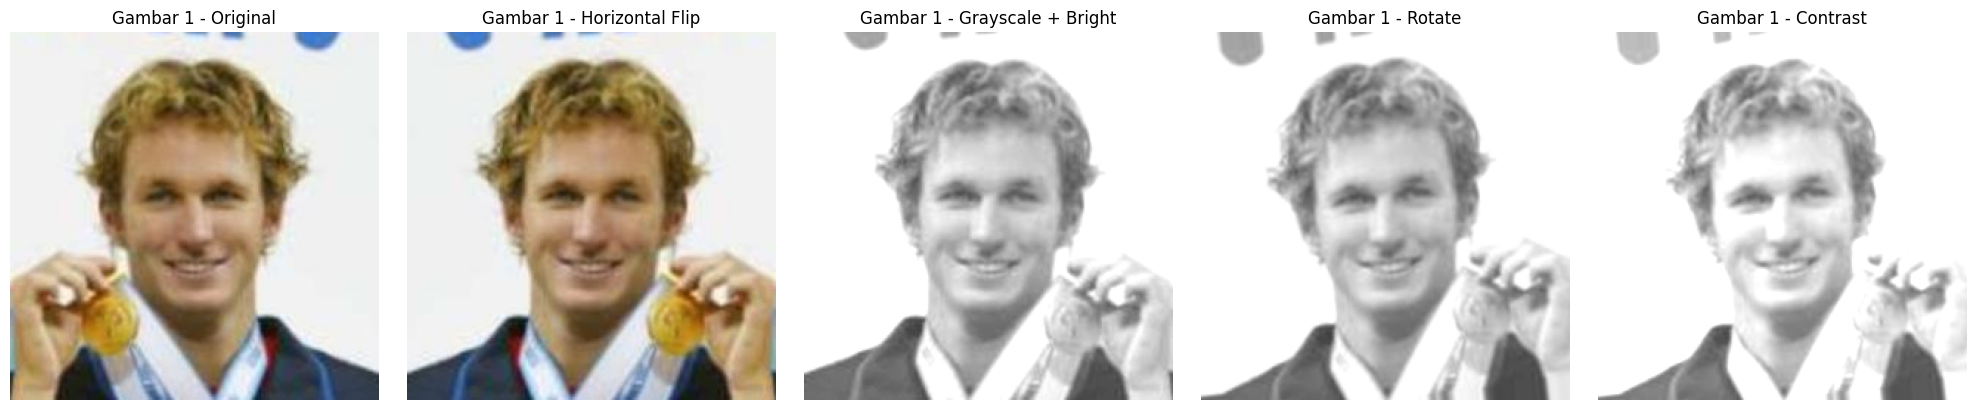


=== VISUALISASI AUGMENTASI GAMBAR 2 ===


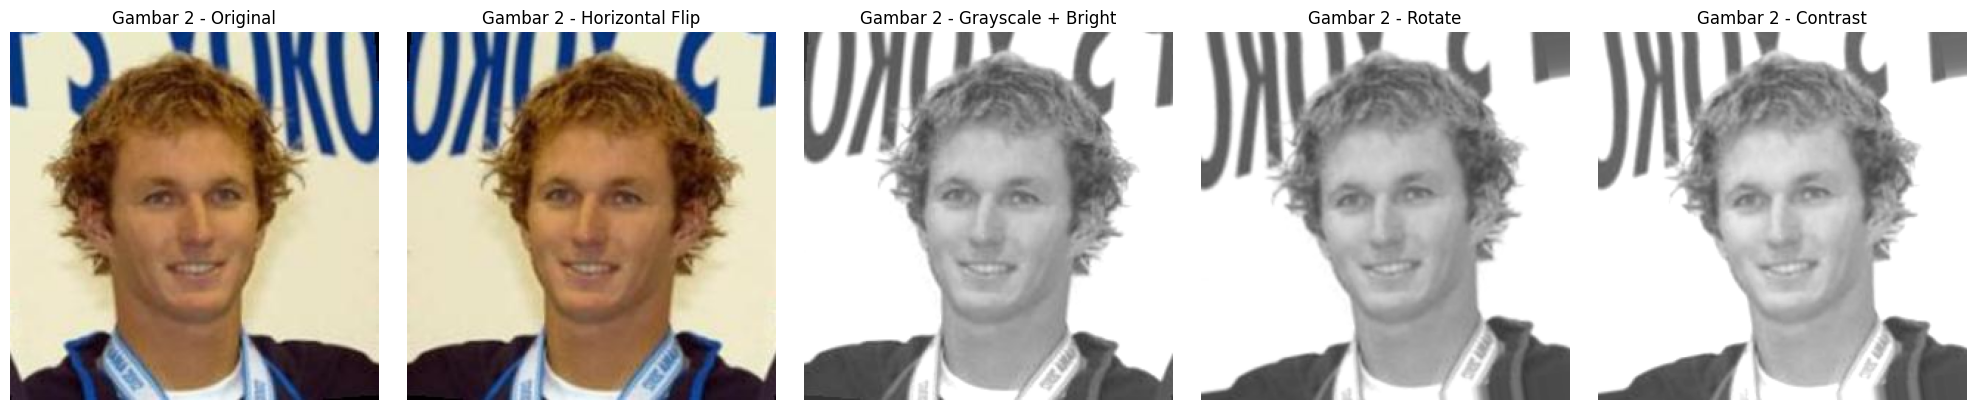


=== PROSES GAMBAR 1 ===

Memproses dengan Facenet...
  Waktu augmentasi: 0.0204s
  Waktu ekstraksi embedding: 2.8527s
  Total waktu: 2.8731s

Memproses dengan Facenet512...
  Waktu augmentasi: 0.0167s
  Waktu ekstraksi embedding: 4.1667s
  Total waktu: 4.1834s

Memproses dengan ArcFace...
  [ArcFace Error] Model ArcFace tidak kompatibel, lewati...

=== PROSES GAMBAR 2 ===

Memproses dengan Facenet...
  Waktu augmentasi: 0.0000s
  Waktu ekstraksi embedding: 2.5034s
  Total waktu: 2.5034s

Memproses dengan Facenet512...
  Waktu augmentasi: 0.0073s
  Waktu ekstraksi embedding: 2.6718s
  Total waktu: 2.6791s

Memproses dengan ArcFace...
  [ArcFace Error] Model ArcFace tidak kompatibel, lewati...

HASIL SIMILARITY
Facenet: Similarity = 0.8603 | Same Person = True
Facenet512: Similarity = 0.8349 | Same Person = True
ArcFace: Gagal memproses

DETAIL WAKTU PREPROCESSING (Contoh: Facenet)
Waktu Augmentasi per operasi:
  original: 0.000000s
  flip: 0.000000s
  grayscale_bright: 0.000000s
  rota

In [9]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from sklearn.metrics.pairwise import cosine_distances
import time
import shutil

# === GANTI DENGAN 2 GAMBAR SPESIFIK ANDA ===
img1_path = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg"  # GANTI DENGAN PATH GAMBAR PERTAMA ANDA
img2_path = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg"  # GANTI DENGAN PATH GAMBAR KEDUA ANDA

# Folder sementara
TEMP_DIR = "temp_aug"
os.makedirs(TEMP_DIR, exist_ok=True)

def augment_image_with_timing(img_bgr):
    """Return list of 5 images dengan augmentasi berantai dan timing untuk setiap operasi"""
    h, w = img_bgr.shape[:2]
    aug_images = []
    timings = {}
    current_img = img_bgr.copy()
    
    # 1. Original
    start = time.time()
    aug_images.append(current_img.copy())
    timings['original'] = time.time() - start

    # 2. Horizontal Flip (dari original)
    start = time.time()
    current_img = cv2.flip(current_img, 1)
    aug_images.append(current_img.copy())
    timings['flip'] = time.time() - start

    # 3. Grayscale + Increase Brightness (dari hasil flip)
    start = time.time()
    gray = cv2.cvtColor(current_img, cv2.COLOR_BGR2GRAY)
    bright = cv2.convertScaleAbs(gray, alpha=1.0, beta=50)
    current_img = cv2.cvtColor(bright, cv2.COLOR_GRAY2BGR)
    aug_images.append(current_img.copy())
    timings['grayscale_bright'] = time.time() - start

    # 4. Rotate 0-15 degrees (dari hasil grayscale+bright)
    start = time.time()
    angle = random.uniform(0, 15)
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    current_img = cv2.warpAffine(current_img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    aug_images.append(current_img.copy())
    timings['rotate'] = time.time() - start

    # 5. Random Contrast (dari hasil rotate)
    start = time.time()
    alpha = random.uniform(0.8, 1.2)
    current_img = cv2.convertScaleAbs(current_img, alpha=alpha, beta=0)
    aug_images.append(current_img.copy())
    timings['contrast'] = time.time() - start

    return aug_images, timings

def save_augmented_images_with_timing(image_path, output_dir=TEMP_DIR):
    """Simpan 5 versi augmentasi dengan timing, kembalikan list path dan timing"""
    start_total = time.time()
    
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise ValueError(f"Gambar tidak ditemukan: {image_path}")
    
    aug_images, aug_timings = augment_image_with_timing(img_bgr)
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    paths = []
    
    save_start = time.time()
    for i, img in enumerate(aug_images):
        temp_path = os.path.join(output_dir, f"{base_name}_aug{i}.jpg")
        cv2.imwrite(temp_path, img)
        paths.append(temp_path)
    save_time = time.time() - save_start
    
    total_time = time.time() - start_total
    aug_timings['save_to_disk'] = save_time
    aug_timings['total_augmentation'] = total_time
    
    return paths, aug_timings

# Model yang digunakan
models = ['Facenet', 'Facenet512', 'ArcFace']

def get_averaged_embedding_with_timing(img_path, model_name):
    # Pilih detektor berdasarkan model
    if model_name == "ArcFace":
        detector = "retinaface"
    else:  # Facenet, Facenet512
        detector = "mtcnn"
    
    try:
        # Timing augmentasi
        aug_start = time.time()
        aug_paths, aug_timings = save_augmented_images_with_timing(img_path)
        aug_total_time = time.time() - aug_start
        
        # Timing embedding extraction
        embeddings = []
        embedding_times = []
        for p in aug_paths:
            emb_start = time.time()
            # Tambahkan penanganan khusus untuk ArcFace
            if model_name == "ArcFace":
                try:
                    emb = DeepFace.represent(
                        img_path=p,
                        model_name=model_name,
                        detector_backend=detector,
                        enforce_detection=False,
                        align=True
                    )[0]['embedding']
                except (AttributeError, TypeError) as e:
                    if "'KerasHistory' object has no attribute 'layer'" in str(e):
                        print(f"  [ArcFace Error] Model ArcFace tidak kompatibel, lewati...")
                        return None, None
                    else:
                        raise e
            else:
                emb = DeepFace.represent(
                    img_path=p,
                    model_name=model_name,
                    detector_backend=detector,
                    enforce_detection=False,
                    align=True
                )[0]['embedding']
            
            emb_time = time.time() - emb_start
            embedding_times.append(emb_time)
            embeddings.append(emb)
        
        # Rata-ratakan embedding
        avg_emb = np.mean(embeddings, axis=0)
        normalized_emb = avg_emb / np.linalg.norm(avg_emb)
        
        total_embedding_time = sum(embedding_times)
        
        timing_info = {
            'augmentation': aug_timings,
            'embedding_extraction': embedding_times,
            'total_embedding_time': total_embedding_time,
            'total_processing_time': aug_total_time + total_embedding_time
        }
        
        return normalized_emb, timing_info
        
    except Exception as e:
        print(f"  [Embedding Error] {img_path}: {e}")
        return None, None

# === Visualisasi Augmentasi ===
def visualize_augmentations(img_path, title_prefix=""):
    """Tampilkan semua hasil augmentasi"""
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"Gambar tidak ditemukan: {img_path}")
        return
    
    aug_images, _ = augment_image_with_timing(img_bgr)
    titles = ['Original', 'Horizontal Flip', 'Grayscale + Bright', 'Rotate', 'Contrast']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, (img, title) in enumerate(zip(aug_images, titles)):
        if len(img.shape) == 3:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        axes[i].imshow(img_rgb)
        axes[i].set_title(f"{title_prefix} - {title}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# === MAIN EXECUTION ===
print("="*60)
print("FACE MATCHING DENGAN 2 GAMBAR SPESIFIK")
print("="*60)

# Visualisasi augmentasi untuk kedua gambar
print("\n=== VISUALISASI AUGMENTASI GAMBAR 1 ===")
visualize_augmentations(img1_path, "Gambar 1")

print("\n=== VISUALISASI AUGMENTASI GAMBAR 2 ===")
visualize_augmentations(img2_path, "Gambar 2")

# Proses kedua gambar
print("\n=== PROSES GAMBAR 1 ===")
emb1_results = {}
for model_name in models:
    print(f"\nMemproses dengan {model_name}...")
    emb1, timing1 = get_averaged_embedding_with_timing(img1_path, model_name)
    emb1_results[model_name] = {'embedding': emb1, 'timing': timing1}
    
    if timing1:
        print(f"  Waktu augmentasi: {timing1['augmentation']['total_augmentation']:.4f}s")
        print(f"  Waktu ekstraksi embedding: {timing1['total_embedding_time']:.4f}s")
        print(f"  Total waktu: {timing1['total_processing_time']:.4f}s")

print("\n=== PROSES GAMBAR 2 ===")
emb2_results = {}
for model_name in models:
    print(f"\nMemproses dengan {model_name}...")
    emb2, timing2 = get_averaged_embedding_with_timing(img2_path, model_name)
    emb2_results[model_name] = {'embedding': emb2, 'timing': timing2}
    
    if timing2:
        print(f"  Waktu augmentasi: {timing2['augmentation']['total_augmentation']:.4f}s")
        print(f"  Waktu ekstraksi embedding: {timing2['total_embedding_time']:.4f}s")
        print(f"  Total waktu: {timing2['total_processing_time']:.4f}s")

# Hitung similarity
print("\n" + "="*60)
print("HASIL SIMILARITY")
print("="*60)

results = []
for model_name in models:
    emb1 = emb1_results[model_name]['embedding']
    emb2 = emb2_results[model_name]['embedding']
    
    if emb1 is not None and emb2 is not None:
        similarity = 1 - cosine_distances([emb1], [emb2])[0][0]
        is_same = similarity > 0.8
        results.append({
            'model': model_name,
            'similarity': similarity,
            'is_same': is_same
        })
        print(f"{model_name}: Similarity = {similarity:.4f} | Same Person = {is_same}")
    else:
        print(f"{model_name}: Gagal memproses")

# Tampilkan timing detail untuk model pertama sebagai contoh
print("\n" + "="*60)
print("DETAIL WAKTU PREPROCESSING (Contoh: Facenet)")
print("="*60)
if 'Facenet' in emb1_results and emb1_results['Facenet']['timing']:
    timing = emb1_results['Facenet']['timing']
    print("Waktu Augmentasi per operasi:")
    for op, t in timing['augmentation'].items():
        if op not in ['total_augmentation', 'save_to_disk']:
            print(f"  {op}: {t:.6f}s")
    print(f"  Save to disk: {timing['augmentation']['save_to_disk']:.6f}s")
    print(f"  Total augmentasi: {timing['augmentation']['total_augmentation']:.6f}s")
    print(f"Total waktu ekstraksi embedding (5 gambar): {timing['total_embedding_time']:.6f}s")

# Bersihkan folder temp
shutil.rmtree(TEMP_DIR)
print(f"\nFolder temporary '{TEMP_DIR}' telah dihapus.")

# Penjelasan akhir
print("\n" + "="*60)
print("PENJELASAN AKHIR")
print("="*60)
print("1. Setiap gambar asli di-augmentasi menjadi 5 versi berbeda")
print("2. SEMUA 5 versi augmentasi dimasukkan ke model secara terpisah")
print("3. Hasilnya: 5 embedding → dirata-ratakan → 1 embedding akhir")
print("4. Normalisasi (L2 norm) adalah bagian PENTING dari preprocessing")
print("   karena memungkinkan penggunaan cosine similarity yang akurat")
print("5. Total gambar yang diproses per gambar asli: 5 gambar augmentasi")